## 💡LangGraph 고객지원 자동화: 큰 그림 이해하기

이 코드는 고객 요청(예: 사과 메일 작성)을 자동으로 처리하는 **3단계 파이프라인**입니다. 핵심은 각 단계가 공유하는 상태(State)를 바탕으로 순차적으로 처리된다는 점입니다.

### 단계 1️⃣: 요청 요약 및 스펙 생성
- 고객 요청을 이해하고, 출력 형식·주의사항·예시 등을 담은 `SupportSpec`이라는 체크리스트 형태로 정리합니다.

### 단계 2️⃣: 시스템 프롬프트 구성
- 위 스펙을 바탕으로, LLM(Gemini)이 잘 이해하도록 시스템 지침문(system prompt)을 자동으로 생성합니다.

### 단계 3️⃣: 최종 응답 초안 생성
- 생성된 시스템 프롬프트를 바탕으로 실제 고객 응답(예: 이메일 초안)을 생성합니다.

LangGraph는 이 과정을 **상태 기반(Stateful)으로 추적**하여 디버깅과 재사용을 쉽게 만듭니다.


In [1]:
!pip3 install --upgrade langgraph langchain langchain_google_genai langchain_community  # 실습 패키지 설치(Colab 기준)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
from langchain_core.rate_limiters import InMemoryRateLimiter  # 호출 빈도 제한 도구
from langchain_google_genai import ChatGoogleGenerativeAI  # Google 모델용 LangChain 래퍼

# 요청 제한(레이트리밋): 분당 10회(≈0.167 rps)  # [포인트] 과금/안정성 위해 필수
support_req_throttle = InMemoryRateLimiter(
    requests_per_second=0.167,  # 초당 요청 허용치
    check_every_n_seconds=0.1,  # 체크 주기
    max_bucket_size=10,  # 버킷 최대치(버스트 허용량)
)

# LLM 인스턴스  # [포인트] 어떤 모델을 쓸지, 어떻게 제한할지 정의
support_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",  # 응답 빠른 플래시 계열(강의 데모용)
    rate_limiter=support_req_throttle  # 위에서 정의한 레이트리밋 적용
)


An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# ---- 구조화된 출력: Pydantic 스키마 정의 ----  # [포인트] LLM 출력 형태를 표준화(일관성↑)
from pydantic import BaseModel, Field  # 데이터 검증/스키마 정의

class SupportSpec(BaseModel):  # 고객지원 스펙(체크리스트) 모델
    request_brief: str = Field(description='고객 요청을 간결·명확하게 재구성')  # 핵심 요약
    reply_format: str = Field(description='응답의 출력 포맷 설명')  # 예: 제목/본문/서명 형태
    sample_ticket: str = Field(description='예시 출력(1개)')  # 한 개 샘플
    handling_tips: str = Field(description='처리 시 주의사항 4가지(개조식)')  # 톤/법적/보안 등
    @property
    def as_markdown(self) -> str:  # 스펙을 마크다운 텍스트로 변환(프롬프트에 주입)
        # Pydantic v2 기준: self.__iter__()는 (key, value) 튜플 이터레이터 제공  # 내부 설명
        return '\n\n'.join([f'## {k}\n {v}' for k, v in self])  # 키/값을 섹션화

In [5]:
from langchain_core.prompts import ChatPromptTemplate

spec_prompt = ChatPromptTemplate([
    ('system', '고객 문의 응대 지침(System Prompt)을 구성합니다. 아래 포맷을 준수해 작성하세요.'),  # 시스템 규칙
    ('user', '{request_brief}')  # 사용자가 입력한 요청 요약을 주입
])

# with_structured_output으로 SupportSpec을 직접 받기  # [포인트] LLM 응답을 바로 Pydantic 스키마로 파싱
spec_chain = spec_prompt | support_llm.with_structured_output(SupportSpec)  # 프롬프트→LLM→스키마 파이프라인

# 예시 인풋(생활→고객지원 도메인으로 치환)  # [포인트] 데모용 요청 문구 (단순/직관 버전)
spec_result = spec_chain.invoke({'request_brief': "배송 지연 사과 메일 작성"})  # 체인 실행→스펙 생성

spec_result  # 노트북에서 객체 확인(디버깅에 유용)
print(spec_result.as_markdown)  # 사람이 읽기 좋은 마크다운으로 미리보기

## request_brief
 배송 지연에 대한 사과 메일

## reply_format
 존칭을 포함한 정중한 사과와 함께 지연 사유와 예상 배송일을 명확하게 안내합니다.

## sample_ticket
 고객님께,

주문하신 상품 배송이 지연되어 대단히 죄송합니다. 현재 택배사 물량 증가로 인해 배송이 평소보다 1~2일 정도 지연되고 있습니다. 예상 배송일은 2024년 5월 15일입니다. 다시 한번 불편을 드려 죄송합니다.

## handling_tips
 1. 정확한 지연 사유 명시
2. 구체적인 예상 배송일자 제시
3. 추가 문의 연락처 안내
4. 재발 방지 노력 강조


In [6]:
# ---- State 정의 및 노드/체인 구성 ----  # [포인트] LangGraph로 단계별 파이프라인 구성
from typing import TypedDict  # 타입 명세(가독성↑)

class TicketFlow(TypedDict):  # 그래프 상태에 담길 키 정의
    request_brief : str  # 입력 요청 요약
    support_spec : SupportSpec  # 구조화된 스펙
    system_prompt_text : str  # LLM용 시스템 프롬프트
    final_reply : str  # 최종 응답 초안

def draft_support_spec(State):  # [포인트] 1단계: 요청→SupportSpec 생성 노드
    prompt = ChatPromptTemplate([
        ('system', '고객 이슈를 요약하고, 출력형식/예시/주의사항을 구조화하세요.'),  # 작업 지시
        ('user', '{request_brief}')  # 현재 상태의 요청 요약 사용
    ])
    chain = prompt | support_llm.with_structured_output(SupportSpec)  # 스펙으로 직접 파싱
    result = chain.invoke({'request_brief': State['request_brief']})  # 실행
    return {'support_spec' : result}  # 다음 노드에 넘길 상태 반환

In [7]:
from langchain_core.output_parsers import StrOutputParser  # 문자열만 뽑는 파서

def compose_system_prompt(State):  # [포인트] 2단계: 스펙→시스템 프롬프트 작성
    prompt = ChatPromptTemplate([
        ('system', '''당신은 고객지원 프롬프트 전문가입니다. 다음 포인트를 참고하여 LLM에 투입할 시스템 프롬프트를 작성하세요.
{points}'''),  # 스펙 요점을 지침으로 삽입
        ('user', '{request_brief}')  # 사용자의 원요청도 함께 제공
    ])
    chain = prompt | support_llm | StrOutputParser()  # LLM 생성→문자열 파싱
    result = chain.invoke({
        'request_brief': State['request_brief'],  # 요청 원문
        'points': State['support_spec'].as_markdown  # 스펙을 마크다운으로 전달
    })
    return {'system_prompt_text' : result}  # 시스템 프롬프트 텍스트 반환

def produce_reply(State):  # [포인트] 3단계: 시스템 프롬프트→최종 답변 생성
    return {'final_reply' : support_llm.invoke(State['system_prompt_text']).content}  # 한 번 더 호출해 초안 생성


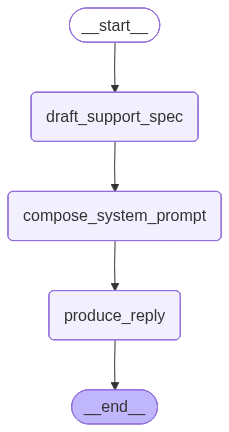

In [8]:

from IPython.display import Image, display  # 시각화에 사용(옵션)
from langgraph.graph import StateGraph, START, END  # 그래프 구성 도구

# 그래프 구성  # [포인트] 3노드 직렬 파이프라인(시작→스펙→프롬프트→답변→끝)
flow = StateGraph(TicketFlow)  # 상태 스키마를 가진 그래프
flow.add_node("draft_support_spec", draft_support_spec)  # 노드1 등록
flow.add_node("compose_system_prompt", compose_system_prompt)  # 노드2 등록
flow.add_node("produce_reply", produce_reply)  # 노드3 등록

flow.add_edge(START, "draft_support_spec")  # 시작→노드1
flow.add_edge("draft_support_spec", "compose_system_prompt")  # 노드1→노드2
flow.add_edge("compose_system_prompt", "produce_reply")  # 노드2→노드3
flow.add_edge("produce_reply", END)  # 노드3→끝

flow_graph = flow.compile()  # 실행 가능한 그래프 객체로 컴파일
flow_graph  # 노트북에서 구조 확인


In [9]:
import pprint  # 예쁜 출력용

# Streaming: 단계별 상태를 출력  # [포인트] 실행 과정을 단계별로 관찰(디버깅/교육 효과↑)
for data in flow_graph.stream({'request_brief': '''반품 안내 메일 작성'''}, stream_mode='values'):
    pprint.pprint(data)  # 현재 상태 스냅샷 출력
    print('----')  # 구분선

data  # 마지막 스텝의 상태 스냅샷이 할당됨(Jupyter 관례)  # 최종 상태 재확인


{'request_brief': '반품 안내 메일 작성'}
----
{'request_brief': '반품 안내 메일 작성',
 'support_spec': SupportSpec(request_brief='반품 절차 안내 메일 초안 작성 요청', reply_format='고객 문의에 대한 답변 형식의 이메일', sample_ticket='안녕하세요. 문의하신 반품 절차는 다음과 같습니다. 1. 반품 신청 페이지에서 신청해주십시오. 2. 택배 기사님이 방문하여 제품을 수거할 예정입니다. 3. 제품 회수 후 검수를 거쳐 환불이 진행됩니다. 감사합니다.', handling_tips='1. 반품 정책을 명확하게 설명해야 합니다. 2. 반품 배송비 관련 안내를 포함해야 합니다. 3. 반품 접수 방법 안내가 필요합니다. 4. 환불 처리 기간에 대한 정보를 제공해야 합니다.')}
----
{'request_brief': '반품 안내 메일 작성',
 'support_spec': SupportSpec(request_brief='반품 절차 안내 메일 초안 작성 요청', reply_format='고객 문의에 대한 답변 형식의 이메일', sample_ticket='안녕하세요. 문의하신 반품 절차는 다음과 같습니다. 1. 반품 신청 페이지에서 신청해주십시오. 2. 택배 기사님이 방문하여 제품을 수거할 예정입니다. 3. 제품 회수 후 검수를 거쳐 환불이 진행됩니다. 감사합니다.', handling_tips='1. 반품 정책을 명확하게 설명해야 합니다. 2. 반품 배송비 관련 안내를 포함해야 합니다. 3. 반품 접수 방법 안내가 필요합니다. 4. 환불 처리 기간에 대한 정보를 제공해야 합니다.'),
 'system_prompt_text': '## 시스템 프롬프트\n'
                       '\n'
                       '**역할:** 당신은 고객 지원 전문가이며, 고객 문의에 대한 답변 이메일을 작성하는 데 '
                    

{'request_brief': '반품 안내 메일 작성',
 'support_spec': SupportSpec(request_brief='반품 절차 안내 메일 초안 작성 요청', reply_format='고객 문의에 대한 답변 형식의 이메일', sample_ticket='안녕하세요. 문의하신 반품 절차는 다음과 같습니다. 1. 반품 신청 페이지에서 신청해주십시오. 2. 택배 기사님이 방문하여 제품을 수거할 예정입니다. 3. 제품 회수 후 검수를 거쳐 환불이 진행됩니다. 감사합니다.', handling_tips='1. 반품 정책을 명확하게 설명해야 합니다. 2. 반품 배송비 관련 안내를 포함해야 합니다. 3. 반품 접수 방법 안내가 필요합니다. 4. 환불 처리 기간에 대한 정보를 제공해야 합니다.'),
 'system_prompt_text': "## 시스템 프롬프트\n\n**역할:** 당신은 고객 지원 전문가이며, 고객 문의에 대한 답변 이메일을 작성하는 데 능숙합니다. 고객의 문의 내용을 정확히 파악하고, 필요한 정보를 명확하고 친절하게 전달하는 것을 목표로 합니다.\n\n**목표:** 고객의 반품 문의에 대한 답변 이메일 초안을 작성합니다. 이메일은 반품 절차, 반품 배송비, 접수 방법, 환불 처리 기간 등 고객이 궁금해할 만한 모든 정보를 포함해야 합니다.\n\n**제약 조건:**\n\n*   답변은 문의에 대한 형식적인 답변이 아닌, 고객에게 실질적인 도움이 되는 정보 위주로 작성합니다.\n*   반품 정책을 명확하게 설명하고, 오해의 소지가 없도록 정확한 용어를 사용합니다.\n*   반품 배송비 관련 정책을 명확하게 안내합니다. 고객 부담 여부, 금액, 부과 조건 등을 상세히 설명합니다.\n*   반품 접수 방법을 단계별로 안내하여 고객이 쉽게 따라 할 수 있도록 합니다. (예: 웹사이트, 앱, 전화 등)\n*   환불 처리 기간에 대한 정보를 제공하여 고객이 환불 시점을 예상할 수 있도록 합니다.\n*   고객의 감정을 공감하고, 친절하고 정중한 어조

In [10]:

from IPython.display import display, Markdown  # 마크다운 렌더링
import textwrap  # 텍스트 들여쓰기 유틸

def as_md_quote(text):  # 결과를 인용 블록 형태로 보기 좋게 출력
  text = text.replace('•', '  *')  # 불릿 보정
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))  # 모든 줄에 > 적용

as_md_quote(data['final_reply'])  # 최종 답변을 인용 블록으로 표시

> ## 출력: (작성된 이메일 초안)
> 
> 안녕하세요, [고객 이름]님.
> 
> [회사 이름] 고객 지원팀 [담당자 이름]입니다. 보내주신 반품 문의 잘 받았습니다. 저희 제품에 불편을 드려 죄송하다는 말씀을 먼저 드립니다.
> 
> 문의하신 제품의 반품 절차에 대해 상세히 안내해 드리겠습니다. 고객님의 상황에 맞춰 최대한 신속하고 편리하게 처리될 수 있도록 최선을 다하겠습니다.
> 
> **반품 정책:**
> 
> 저희 [회사 이름]은 고객님께서 제품을 수령하신 날로부터 **14일 이내**에 반품을 접수하실 수 있도록 규정하고 있습니다. 다만, 다음의 경우에는 반품이 어려울 수 있습니다.
> 
> *   제품 포장이 개봉되었거나 훼손된 경우
> *   제품의 가치가 현저히 감소한 경우 (예: 사용 흔적, 오염 등)
> *   시간 경과에 따라 재판매가 곤란한 경우 (예: 신선식품, 맞춤 제작 상품 등)
> *   전자상거래 등에서의 소비자보호에 관한 법률에 따라 청약철회가 제한되는 경우
> 
> 더 자세한 내용은 [회사 이름] 웹사이트의 [반품/교환 정책 페이지 링크]에서 확인하실 수 있습니다.
> 
> **반품 배송비:**
> 
> 반품 배송비는 반품 사유에 따라 고객님 또는 저희 [회사 이름]에서 부담하게 됩니다.
> 
> *   **단순 변심 (색상, 사이즈, 디자인 불만족 등):** 고객님께서 왕복 배송비 [금액]원을 부담하셔야 합니다.
> *   **제품 불량, 오배송:** 저희 [회사 이름]에서 모든 배송비를 부담합니다.
> 
> 반품 배송비는 환불 금액에서 차감될 수 있으며, 고객님께서 직접 택배사를 통해 선불로 보내주시는 것도 가능합니다. (단, 착불로 보내실 경우 반송될 수 있습니다.)  만약 제품 불량 또는 오배송으로 판단되시는 경우, 반품 접수 전에 불량 부분을 사진이나 영상으로 촬영하여 첨부해주시면 더욱 신속하게 처리해 드릴 수 있습니다.
> 
> **반품 접수 방법:**
> 
> 다음 방법 중 편하신 방법을 선택하여 반품을 접수하실 수 있습니다.
> 
> 1.  **웹사이트/앱:**
>     *   [회사 이름] 웹사이트 ([웹사이트 주소]) 또는 앱에 로그인합니다.
>     *   '마이페이지' > '주문 내역'으로 이동합니다.
>     *   반품하려는 주문을 선택하고 '반품 신청' 버튼을 클릭합니다.
>     *   반품 사유를 선택하고, 필요한 정보를 입력합니다. (예: 환불 계좌 정보)
>     *   제출하기 전에 모든 정보를 다시 한번 확인하신 후 '반품 신청 완료' 버튼을 클릭합니다.
> 2.  **고객센터 전화:**
>     *   [고객 지원 전화번호]로 전화하여 반품을 접수합니다.
>     *   상담원에게 주문 번호와 반품 사유를 말씀해 주시면 됩니다.
> 
> 반품 접수가 완료되면, 1~3일 이내에 택배 기사님께서 고객님께 연락을 드리고 방문 수거를 진행할 예정입니다.  혹시라도 3일 이내에 연락을 받지 못하셨다면, 저희 고객센터로 다시 연락 부탁드립니다.
> 
> **환불 처리 기간:**
> 
> 반품된 제품이 저희 물류센터에 도착하여 검수를 마치면, 환불이 진행됩니다. 환불 완료까지는 **최대 7일 (영업일 기준)**이 소요될 수 있습니다. 환불은 고객님께서 제공해주신 계좌로 입금됩니다.
> 
> 환불 진행 상황은 '마이페이지' > '주문 내역'에서 해당 주문을 클릭하시면 확인하실 수 있습니다.  만약 7일이 지나도 환불이 완료되지 않았다면, [고객 지원 이메일 주소]로 문의해 주시면 신속하게 확인해 드리겠습니다.
> 
> **추가 문의:**
> 
> 궁금한 점이 있거나, 반품 과정에 어려움이 있으시면 언제든지 [고객 지원 이메일 주소] 또는 [고객 지원 전화번호]로 문의해 주시기 바랍니다.  최대한 빠르고 정확하게 답변드리도록 노력하겠습니다.
> 
> 저희 제품 이용에 불편을 드린 점 다시 한번 사과드립니다.  더 나은 서비스로 고객님께 만족을 드릴 수 있도록 최선을 다하겠습니다.
> 
> 감사합니다.
> 
> [회사 이름] 고객 지원팀 [담당자 이름] 드림